## Analysis of prediction distributions for tumor suppressor genes

Looking at some distributions of mutation prediction models by hand, we can see that some of them are very unimodal (samples with a mutation mostly have predicted probabilities close to 1), and some of them have higher variance/are bimodal (many samples with a mutation have predicted probabilities close to 0). We noticed that many of the higher variance genes are tumor suppressors, so this notebook explores that further.

Our guess is that this is occurring because [two hits (deleterious mutations) are required](https://en.wikipedia.org/wiki/Two-hit_hypothesis) to inactivate most tumor suppressors. We want to see if the false negatives with low predicted probabilities only have a single mutation in the gene of interest (i.e. only one allele is mutated).

In [1]:
import os
import gzip
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
mutated_samples_dir = Path('./data', 'mutated_samples')
mutated_samples_dir.mkdir(exist_ok=True)

### Load results from 1_get_mutation_counts, and filter to relevant mutations

In [3]:
gene = 'APC'
mutated_samples_file = mutated_samples_dir / '{}_mutated_samples.tsv'.format(gene)

if mutated_samples_file.is_file():
    print('file already exists, loading from file')
    mutants_df = pd.read_csv(mutated_samples_file, sep='\t', index_col=0)
else:
    print('file does not exist, use 1_get_mutation_counts.ipynb to generate it')
    mutants_df = pd.DataFrame()

file already exists, loading from file


In [4]:
print(mutants_df.shape)
mutants_df.iloc[:5, :20]

(1482, 114)


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1
0,APC,0,.,GRCh37,5,112170682,112170682,+,Missense_Mutation,SNP,G,G,T,.,.,TCGA-04-1357-01A-01W-0492-08,TCGA-04-1357-11A-01W-0492-08,G,G,.
1,APC,0,.,GRCh37,5,112175975,112175975,+,Missense_Mutation,SNP,G,G,A,novel,.,TCGA-05-4382-01A-01D-1931-08,TCGA-05-4382-10A-01D-1265-08,G,G,.
2,APC,0,.,GRCh37,5,112177721,112177721,+,Missense_Mutation,SNP,C,C,A,novel,.,TCGA-05-4396-01A-21D-1855-08,TCGA-05-4396-10A-01D-1855-08,C,C,.
3,APC,0,.,GRCh37,5,112175225,112175225,+,Missense_Mutation,SNP,G,G,C,.,.,TCGA-05-4397-01A-01D-1265-08,TCGA-05-4397-10A-01D-1265-08,G,G,.
4,APC,0,.,GRCh37,5,112175532,112175533,+,Frame_Shift_Ins,INS,-,-,A,.,.,TCGA-05-4402-01A-01D-1265-08,TCGA-05-4402-10A-01D-1265-08,-,-,.


In [5]:
print(mutants_df['Variant_Classification'].unique())

['Missense_Mutation' 'Frame_Shift_Ins' "3'UTR" 'Silent'
 'Nonsense_Mutation' 'Frame_Shift_Del' 'Splice_Site' 'In_Frame_Del'
 'In_Frame_Ins' "5'UTR" 'Intron']


In [6]:
mutants_df['sample_id'] = mutants_df['Tumor_Sample_Barcode'].str.slice(start=0, stop=15)
cols = ['sample_id', 'Tumor_Sample_Barcode', 'Hugo_Symbol', 'Variant_Classification', 'Variant_Type',
        'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'CLIN_SIG', 'VARIANT_CLASS']
mutants_df.loc[:, cols].head()

,sample_id,Tumor_Sample_Barcode,Hugo_Symbol,Variant_Classification,Variant_Type,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,CLIN_SIG,VARIANT_CLASS
0,TCGA-04-1357-01,TCGA-04-1357-01A-01W-0492-08,APC,Missense_Mutation,SNP,112170682,112170682,G,G,T,.,SNV
1,TCGA-05-4382-01,TCGA-05-4382-01A-01D-1931-08,APC,Missense_Mutation,SNP,112175975,112175975,G,G,A,.,SNV
2,TCGA-05-4396-01,TCGA-05-4396-01A-21D-1855-08,APC,Missense_Mutation,SNP,112177721,112177721,C,C,A,.,SNV
3,TCGA-05-4397-01,TCGA-05-4397-01A-01D-1265-08,APC,Missense_Mutation,SNP,112175225,112175225,G,G,C,.,SNV
4,TCGA-05-4402-01,TCGA-05-4402-01A-01D-1265-08,APC,Frame_Shift_Ins,INS,112175532,112175533,-,-,A,.,insertion


In [7]:
# filter mutation types to non-silent ones
# https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/process_sample_freeze.py#L72
mutations = {
    'Frame_Shift_Del',
    'Frame_Shift_Ins',
    'In_Frame_Del',
    'In_Frame_Ins',
    'Missense_Mutation',
    'Nonsense_Mutation',
    'Nonstop_Mutation',
    'RNA',
    'Splice_Site',
    'Translation_Start_Site',
}

sample_count = (mutants_df
    .drop_duplicates(cols)
    .query("Variant_Classification in @mutations")
    .groupby('sample_id')
    .count()
    .iloc[:, 0]
)
print(sample_count.shape)
sample_count.sort_values(ascending=False).head()

(828,)


sample_id
TCGA-CA-6717-01    9
TCGA-B5-A3FA-01    8
TCGA-F5-6814-01    8
TCGA-AX-A05Z-01    7
TCGA-CM-6166-01    7
Name: Hugo_Symbol, dtype: int64

Text(0, 0.5, 'number of samples')

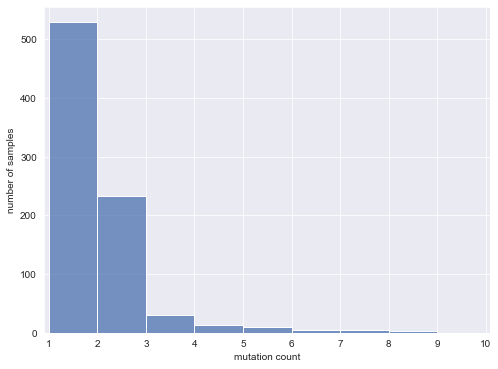

In [8]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(sample_count, binwidth=1)
plt.xlim(0.9, max(sample_count)+1.1)
plt.xticks(range(1, max(sample_count)+2))
plt.xlabel('mutation count')
plt.ylabel('number of samples')

### Add copy number info to count

We get this information from [the `pancancer` repo](https://github.com/greenelab/pancancer/tree/master/data), which [comes from GISTIC run on the TCGA samples](https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/download_data.sh#L33). The version of the copy number info in the `pancancer` repo is "thresholded", which means each sample is described as having a shallow/deep copy change, or no copy change, in the given gene. This is as opposed to the CNV data on the GDC website, which just gives (relative) copy number ratios for each CNV without the thresholding.

For now, we just assume any deep copy change = 1 mutation, and we don't use shallow copy changes. This is what we've done for our classifiers in the past.

We may look into getting more granular CNV info in the future.

In [9]:
import pickle as pkl

# get mutation data from mpmp repo
with open('/home/jake/research/mpmp/data/pancancer_data.pkl', 'rb') as f:
    pancancer_data = pkl.load(f)
    
copy_loss_df = pancancer_data[2]
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9074, 25128)


,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [10]:
copy_count = copy_loss_df.loc[:, gene]
print(copy_count.shape)
print(copy_count.isna().sum())
copy_count.head()

(9074,)
0


TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
Name: APC, dtype: int64

In [11]:
shared_samples = copy_count[copy_count > 0].index.union(sample_count.index)
sample_count = (sample_count
    .reindex(shared_samples)
    .fillna(0)
)
copy_count = (copy_count
    .reindex(shared_samples)
    .fillna(0)
)
sample_count = (sample_count + copy_count).astype(int)
sample_count.name = 'mutation_count'
print(sample_count.shape)
print(sample_count.isna().sum())
sample_count.head()

(889,)
0


TCGA-04-1357-01    1
TCGA-05-4382-01    1
TCGA-05-4389-01    1
TCGA-05-4396-01    1
TCGA-05-4397-01    1
Name: mutation_count, dtype: int64

Text(0, 0.5, 'number of samples')

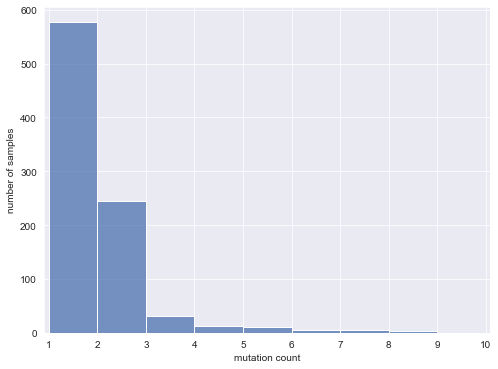

In [12]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(sample_count, binwidth=1)
plt.xlim(0.9, max(sample_count)+1.1)
plt.xticks(range(1, max(sample_count)+2))
plt.xlabel('mutation count')
plt.ylabel('number of samples')

In [13]:
mutants_df.loc[mutants_df.sample_id == sample_count.sort_values(ascending=False).index[100], cols]

,sample_id,Tumor_Sample_Barcode,Hugo_Symbol,Variant_Classification,Variant_Type,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,CLIN_SIG,VARIANT_CLASS
352,TCGA-AA-A01S-01,TCGA-AA-A01S-01A-21W-A096-10,APC,Nonsense_Mutation,SNP,112154963,112154963,C,C,T,.,SNV
353,TCGA-AA-A01S-01,TCGA-AA-A01S-01A-21W-A096-10,APC,Nonsense_Mutation,SNP,112164616,112164616,C,C,T,pathogenic,SNV


### Integrate mutation data and mpmp prediction distributions

Here, we retrieve the prediction distributions (mutation probabilities) from our mutation prediction models trained using gene expression, which we generated in [mpmp](https://github.com/greenelab/mpmp).

In [14]:
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [15]:
print(mutation_df.loc[:, gene].sum())
mutation_df.loc[:, gene].head()

733


SAMPLE_BARCODE
TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
Name: APC, dtype: int64

In [16]:
# get prediction data also from mpmp
preds_dir = Path('/home/jake/data/vogelstein_preds_12_10_2021/')
gene_file = preds_dir / 'gene/{}/{}_expression_signal_classify_s42_preds.tsv.gz'.format(gene, gene)
preds_df = pd.read_csv(gene_file, sep='\t', index_col=0)
preds_df.head()

,fold_no,true_class,score,positive_prob
TCGA-05-4244-01,0,0,-1.51050,0.18087
TCGA-05-4249-01,0,0,-1.03580,0.26197
TCGA-05-4250-01,0,0,-0.51716,0.37352
TCGA-05-4397-01,0,1,-0.56367,0.36270
TCGA-05-4402-01,0,1,-1.35370,0.20526


Text(0.5, 1.0, 'APC')

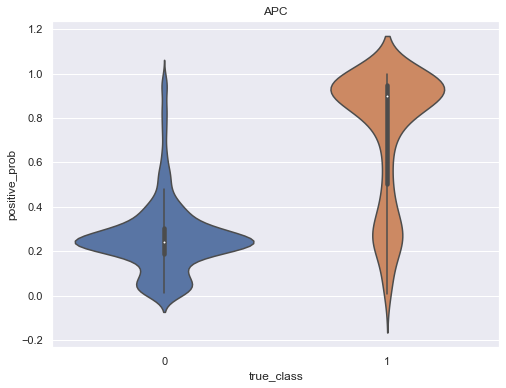

In [17]:
sns.set()
sns.violinplot(data=preds_df, x='true_class', y='positive_prob')
plt.title(gene)

In [18]:
# merge predictions with sample mutation count info
probs_df = preds_df.merge(sample_count, how='left', left_index=True, right_index=True)
probs_df.rename(columns={'Hugo_Symbol': 'mutation_count'}, inplace=True)
probs_df['mutation_count'] = probs_df['mutation_count'].fillna(0).astype(int)

# threshold mutation count into 3 categories (0/1/2+ total mutations)
probs_df.loc[probs_df.mutation_count > 1, 'mutation_count'] = '2+'
probs_df['mutation_count'] = probs_df.mutation_count.astype(str)

probs_df.head()

,fold_no,true_class,score,positive_prob,mutation_count
TCGA-05-4244-01,0,0,-1.51050,0.18087,0
TCGA-05-4249-01,0,0,-1.03580,0.26197,0
TCGA-05-4250-01,0,0,-0.51716,0.37352,0
TCGA-05-4397-01,0,1,-0.56367,0.36270,1
TCGA-05-4402-01,0,1,-1.35370,0.20526,1


In [19]:
# make sure that all samples with a true class of 1 have 1 or more mutations observed
# and make sure that all samples with a true class of 0 have 0 mutations observed
#
# this is essentially just a check that our downloaded maf file matches what was
# used to generate the classifier labels (it should)
assert np.array_equal(
    probs_df.loc[probs_df.true_class == 0, :].mutation_count.unique(), ['0']
)
assert np.array_equal(
    probs_df.loc[probs_df.true_class == 1, :].mutation_count.unique(), ['1', '2+']
)

Text(0.5, 1.0, 'APC observed mutation count vs. predicted probability, averaged over all cancer types')

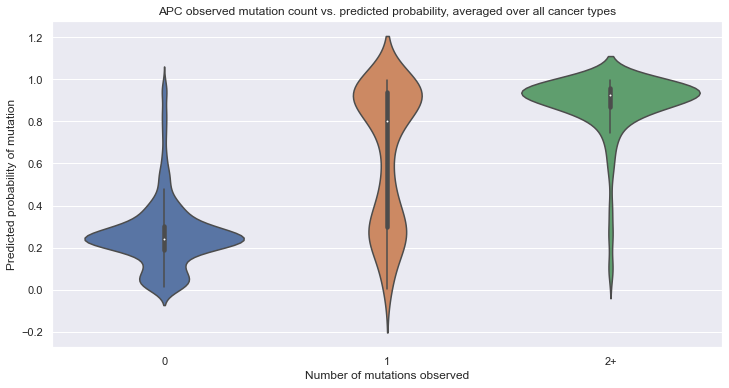

In [20]:
sns.set({'figure.figsize': (12, 6)})
sns.violinplot(data=probs_df, x='mutation_count', y='positive_prob')
plt.xlabel('Number of mutations observed')
plt.ylabel('Predicted probability of mutation')
plt.title('{} observed mutation count vs. predicted probability, averaged over all cancer types'.format(gene))

### Segment analysis by cancer type

Do the same as above, but with samples split by cancer type. We'll display the top few cancer types (by number of samples) for each variant.

In [21]:
exp_sample_info_file = Path('/home/jake/research/mpmp/data/sample_info/tcga_expression_sample_identifiers.tsv')
sample_info_df = pd.read_csv(exp_sample_info_file, sep='\t', index_col=0)
sample_info_df.head()

,sample_type,cancer_type,id_for_stratification
sample_id,,,
TCGA-02-0047-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-0055-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2483-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2485-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2486-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [22]:
probs_cancer_type_df = (probs_df
    .merge(
        sample_info_df.drop(columns=['sample_type', 'id_for_stratification']),
        left_index=True, right_index=True
    )
)
probs_cancer_type_df.head()

,fold_no,true_class,score,positive_prob,mutation_count,cancer_type
TCGA-05-4244-01,0,0,-1.51050,0.18087,0,LUAD
TCGA-05-4249-01,0,0,-1.03580,0.26197,0,LUAD
TCGA-05-4250-01,0,0,-0.51716,0.37352,0,LUAD
TCGA-05-4397-01,0,1,-0.56367,0.36270,1,LUAD
TCGA-05-4402-01,0,1,-1.35370,0.20526,1,LUAD


In [23]:
cancer_type_counts = (probs_cancer_type_df
    .groupby('cancer_type')
    .count()
    .fold_no
    .sort_values(ascending=False)
)
cancer_type_counts.head()

cancer_type
LUAD    472
LUSC    453
BLCA    390
STAD    333
COAD    288
Name: fold_no, dtype: int64

LUAD
LUSC
BLCA
STAD
COAD
SKCM


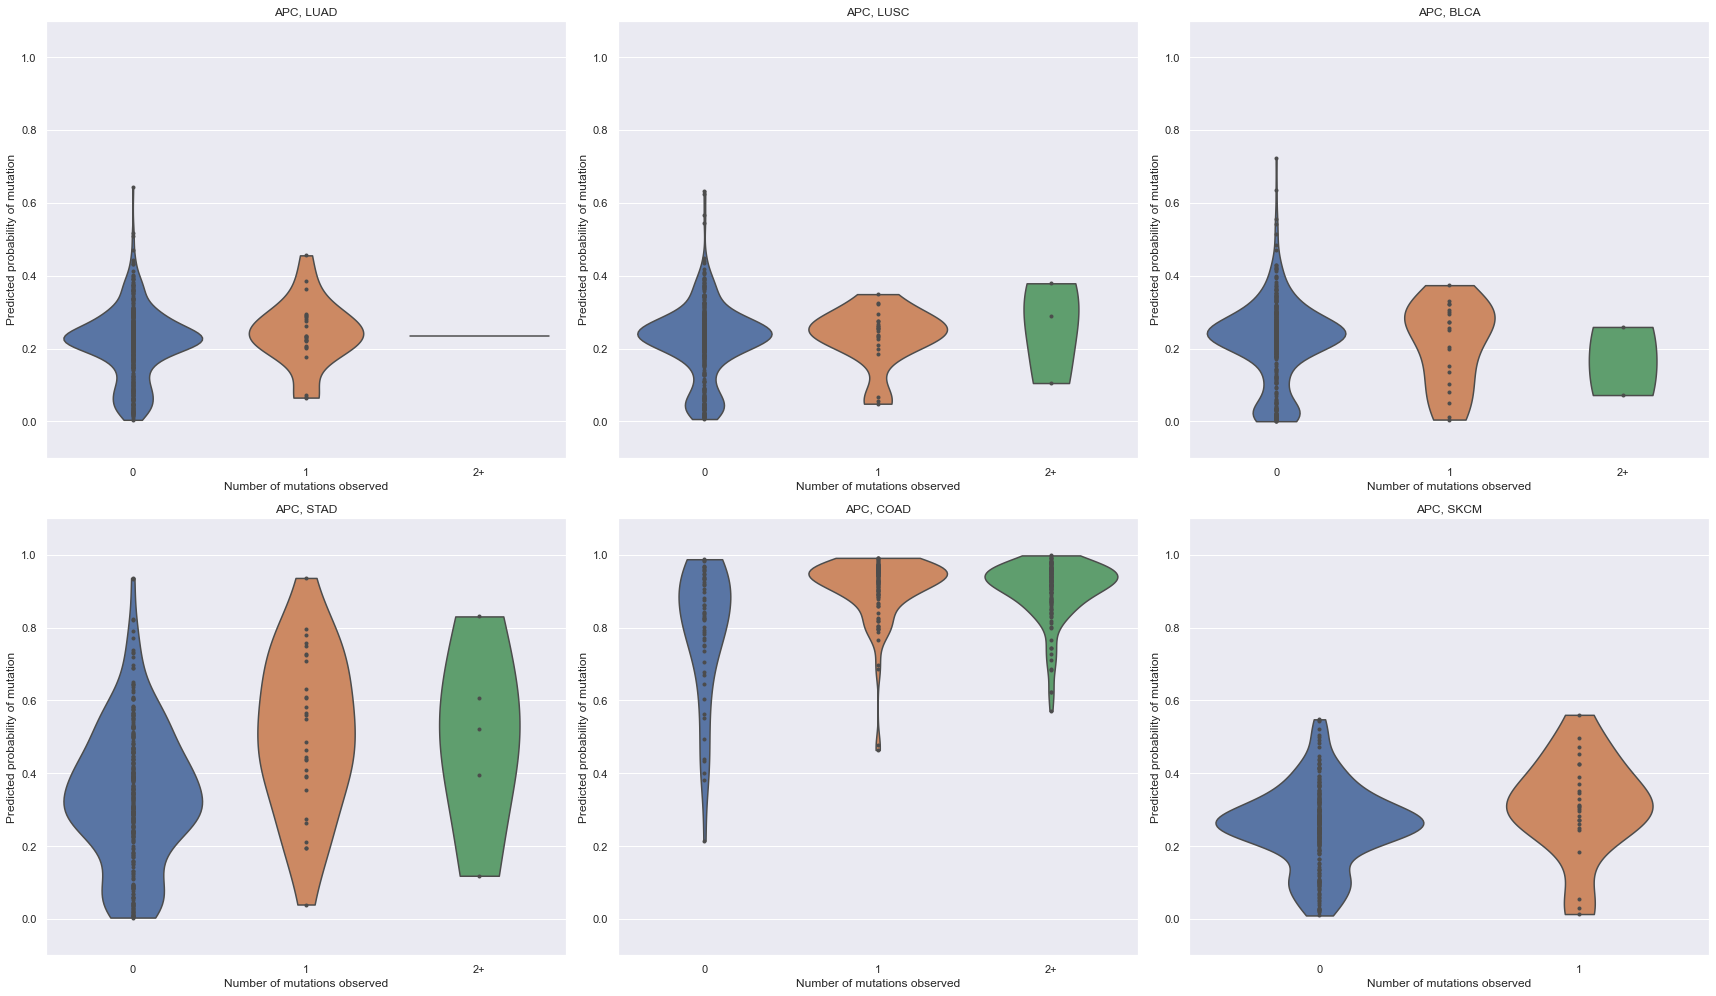

In [24]:
sns.set({'figure.figsize': (24, 14)})
fig, axarr = plt.subplots(2, 3)

for ix, cancer_type in enumerate(cancer_type_counts.index[:6]):
    print(cancer_type)
    ax = axarr[ix // 3, ix % 3]
    plot_df = (
        probs_cancer_type_df[probs_cancer_type_df.cancer_type == cancer_type]
          .sort_values(by='mutation_count')
    )
    sns.violinplot(data=plot_df, x='mutation_count', y='positive_prob',
                   inner='point', dodge=True, cut=0, ax=ax)
    ax.set_title(gene + ', ' + cancer_type)
    ax.set_xlabel('Number of mutations observed')
    ax.set_ylabel('Predicted probability of mutation')
    ax.set_ylim(-0.1, 1.1)
    
plt.tight_layout()

When we look at these results [for a few different tumor suppressors](https://docs.google.com/presentation/d/1gBModofZ0GRtSxBAWhErfzauxD0BpRu-mFVeHei0c-Q/edit?usp=sharing), we can see that some of them (ARID1A, FBXW7, RB1 to a lesser extent) do seem to show worse predictions for samples with one mutation than for samples with 2+ mutations, which could be a result of these genes requiring 2 distinct mutations to be inactivated.

For some other genes (TP53, PTEN) we don't see this effect. TP53 and PTEN are sometimes characterized as ["haploinsufficient" TSGs](https://pubmed.ncbi.nlm.nih.gov/21125671/), meaning that when a single allele of either gene is mutated it can affect protein levels (and cancer risk) substantially. This could be the reason that we see higher predicted probabilities for samples with a single mutation in these genes.

These examples are somewhat cherry-picked, though, and this analysis makes a lot of (over)simplifications we could dig further into in the future.